In [1]:
# manipulation des données
import numpy as np
import pandas as pd

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# sklearn preprocessing pour le traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Suppression des alertes
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../Data/1.normalized_dataset_completed.csv")

In [3]:
import ast

array_list = df['description_token'].values
data_list = []
for item in array_list:
    data_list.append(ast.literal_eval(item))

df['description_token'] = data_list
df

,product_name,product_category_tree,description,description_token,words
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,"[key, feature, elegance, polyester, multicolor...",key feature elegance polyester multicolor abst...
1,Sathiyas Cotton Bath Towel,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,"[specification, sathiyas, cotton, bath, towel,...",specification sathiyas cotton bath towel bath...
2,Eurospa Cotton Terry Face Towel Set,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,"[key, feature, eurospa, cotton, terry, face, t...",key feature eurospa cotton terry face towel se...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[key, feature, santosh, royal, fashion, cotton...",key feature santosh royal fashion cotton print...
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...,"[key, feature, jaipur, print, cotton, floral, ...",key feature jaipur print cotton floral king si...
...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Baby Care,Oren Empower Extra Large Self Adhesive Sticker...,"[oren, empower, extra, large, self, adhesive, ...",oren empower extra large self adhesive sticker...
1046,Wallmantra Large Vinyl Sticker Sticker,Baby Care,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"[wallmantra, large, vinyl, sticker, sticker, p...",wallmantra large vinyl sticker sticker pack p...
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"[buy, uberlyfe, extra, large, pigment, polyvin...",buy uberlyfe extra large pigment polyvinyl fil...
1048,Wallmantra Medium Vinyl Sticker Sticker,Baby Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"[buy, wallmantra, medium, vinyl, sticker, stic...",buy wallmantra medium vinyl sticker sticker r ...


In [4]:
df['cluster'] = 0
df.loc[df['product_category_tree'] == 'Home Furnishing', 'cluster'] = 0
df.loc[df['product_category_tree'] == 'Baby Care', 'cluster'] = 1
df.loc[df['product_category_tree'] == 'Watches', 'cluster'] = 2
df.loc[df['product_category_tree'] == 'Home Decor & Festive Needs', 'cluster'] = 3
df.loc[df['product_category_tree'] == 'Kitchen & Dining', 'cluster'] = 4
df.loc[df['product_category_tree'] == 'Beauty and Personal Care', 'cluster'] = 5
df.loc[df['product_category_tree'] == 'Computers', 'cluster'] = 6

In [5]:
l_cat = list(set(df['product_category_tree']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]['product_category_tree'])) for i in range(len(df))]

catégories :  ['Baby Care', 'Kitchen & Dining', 'Computers', 'Beauty and Personal Care', 'Home Decor & Festive Needs', 'Watches', 'Home Furnishing']


In [6]:
from nltk.tokenize import word_tokenize

df['words'] = df['words'].astype(str)
for i in range(len(df['words'])):
    tokenize_description = word_tokenize(df['words'][i])
    df['description_token'][i] = tokenize_description

In [7]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

2023-12-21 15:46:11.154488: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df['words'].to_list()
sentences_array = []
for sentence in sentences:
    #print(sentence)
    if isinstance(sentence, str):
        sentences_array.append(gensim.utils.simple_preprocess(sentence))
    else : 
        sentences_array.append([])

In [9]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 29
Word2Vec trained


In [10]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4466


In [11]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.0052
Embedding matrix: (4466, 300)


In [12]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1339800   
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 1339800 (5.11 MB)
Trainable params: 1339800 (5.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 928us/step


(1050, 300)

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings)

df_tsne = pd.DataFrame({"tsne_1" : X_tsne[:, 0], "tsne_2" : X_tsne[:, 1], "cluster" : df['cluster']})

In [16]:
X = df_tsne.drop('cluster', axis=1).values

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)
df_tsne['cluster_predict'] = kmeans.fit_predict(X)

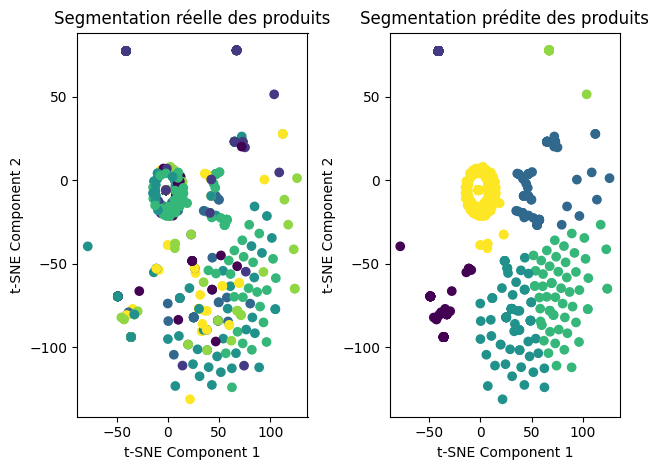

In [18]:
plt.subplot(1, 2, 1)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=df_tsne['cluster'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation réelle des produits')

plt.subplot(1, 2, 2)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=df_tsne['cluster_predict'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation prédite des produits')

plt.tight_layout()
plt.show()

In [19]:
from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(df_tsne['cluster'], kmeans.labels_),4)
ARI

0.0447